In [1]:
## custom
import utils, graph, vis
import optimization as O


## third party
from PIL import Image
from natsort import natsorted
import networkx as nx
import lovasz_losses as L


## sys
import random
import time
from glob import glob

## numeric
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


## generate a graph

generating graph...
2000 nodes
calculating all pairs shortest path...


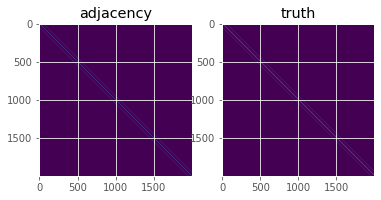

CPU times: user 45.4 s, sys: 254 ms, total: 45.7 s
Wall time: 46.2 s


In [12]:
%%time

print('generating graph...')
# G = nx.balanced_tree(2,3)
G = nx.grid_2d_graph(40,50)
# G = file2graph('./facebook/0.edges')
print(len(G.nodes), 'nodes')

print('calculating all pairs shortest path...')
D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
W = 1/(D+1e-4)**2
adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
truth = adj + torch.eye(adj.shape[0], device=device)

# print('k2i', k2i)

plt.subplot(121)
plt.imshow(adj)
plt.title('adjacency')
plt.subplot(122)
plt.imshow(truth)
plt.title('truth')
plt.show()

## Optimize via Stochastic Gradient Descent (SGD)

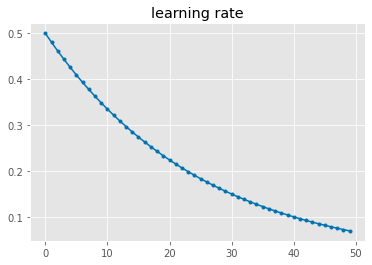

In [18]:
# delete old
!rm -r fig
!mkdir fig

niter = 20000

def getLR(i):
    base_lr = 0.5
    return np.exp(-i*2/niter) * base_lr


pos = torch.rand(len(G.nodes), 2, device=device)
pos.requires_grad_(True)

optimizer = optim.SGD([pos], lr=0.5, momentum=0.9, nesterov=True)
# optimizer = optim.Adam([pos], lr=0.1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, getLR)




lrs = [getLR(i) for i in range(0,niter,int(niter / 50))]
plt.plot(lrs, '.-')
plt.title('learning rate')

iterBar = tqdm(range(niter))
lossHistory = []
totalTime = 0

In [19]:
VIS = True
gClamp = 0.1

sampleSize = int(len(G.nodes))
for i in iterBar:
    
    t0 = time.time()
    optimizer.zero_grad()
    
#     samples = getSamples(G, 5, includeNeighbors=False)
#     for si, src in enumerate(samples):
#         for dst in samples[si+1:]:
#             stress_update_ij(X, D, W, src, dst, getLR(i))
            
#     eu = edge_uniformity(X, G, samples)
    loss = (
          1.0 * O.stress(pos, D, W, sampleSize)
#         + 0.5 * O.edge_uniformity(pos, G, k2i, sampleSize)
        
        ## TODO: do it efiiciently and stochastically
#         + 0.5 * O.crossing_angle_maximization(pos, G, k2i, sampleSize)
#         + 0.5 * O.neighborhood_preservation(pos, G, k2i, sampleSize)
#         + 0.5 * O.crossings(pos, G, k2i, sampleSize)
#         + 0.5 * O.aspect_ratio(pos, G, k2i, sampleSize)
#         + 0.5 * O.angular_resolution(pos, G, k2i, sampleSize)
    )
    loss.backward()
    pos.grad.clamp_(-gClamp, gClamp)
    optimizer.step()
    
    if scheduler is not None:
        scheduler.step()
    
    
    
    
    
    ##debug info
    dt = time.time() - t0
    totalTime += dt
    if i % int(niter/100) == int(niter/100)-1:
        iterBar.set_postfix({'loss': loss.item()})
    lossHistory.append(loss.item())
    
    
    ##vis
    if VIS and i % int(niter/10) == int(niter/10)-1:
        iterBar.set_postfix({
            'loss': loss.item(),
#             'eu': f'{eu.item():.2e}',
#             'st': f'{st.item():.2e}',
        })
        
        x = pos.detach().cpu().numpy()
        pos_i = {k: x[k2i[k], :2] for k in G.nodes}
        display.clear_output(wait=True)
        vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)


KeyboardInterrupt: 

In [ ]:
x = pos.detach().cpu().numpy()
pos_i = {k: x[k2i[k], :2] for k in G.nodes}
vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# Create a gif from images in fig/

frames = []
imgs = natsorted(glob('fig/*.png'))

for img in imgs:
    new_frame = Image.open(img)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)